In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pymysql
import pylab as pl
import numpy as np
import pandas as pd
import os
import csv
from gcloud import storage
from oauth2client.service_account import ServiceAccountCredentials
import seaborn as sns
import json
from decimal import Decimal
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud 
import math, re, string, requests, json
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.stem import PorterStemmer, WordNetLemmatizer
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
plt.rcParams['figure.figsize'] = (30, 6)

C:\Users\nehah\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Connect to the database.
connection = pymysql.connect(host='127.0.0.1',
                             user='root',
                             password='neha',                             
                             db='simpsons',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
 
print ("connect successful!!")


connect successful!!


In [3]:
df_characters = pd.read_sql("select  * from characters",con=connection);
df_locations=pd.read_sql("select  * from locations",con=connection);
df_episodes=pd.read_sql("select  * from episode",con=connection);
df_script_lines=pd.read_sql("select  * from script_lines",con=connection);

The Simpsons characters who have spoken the most words

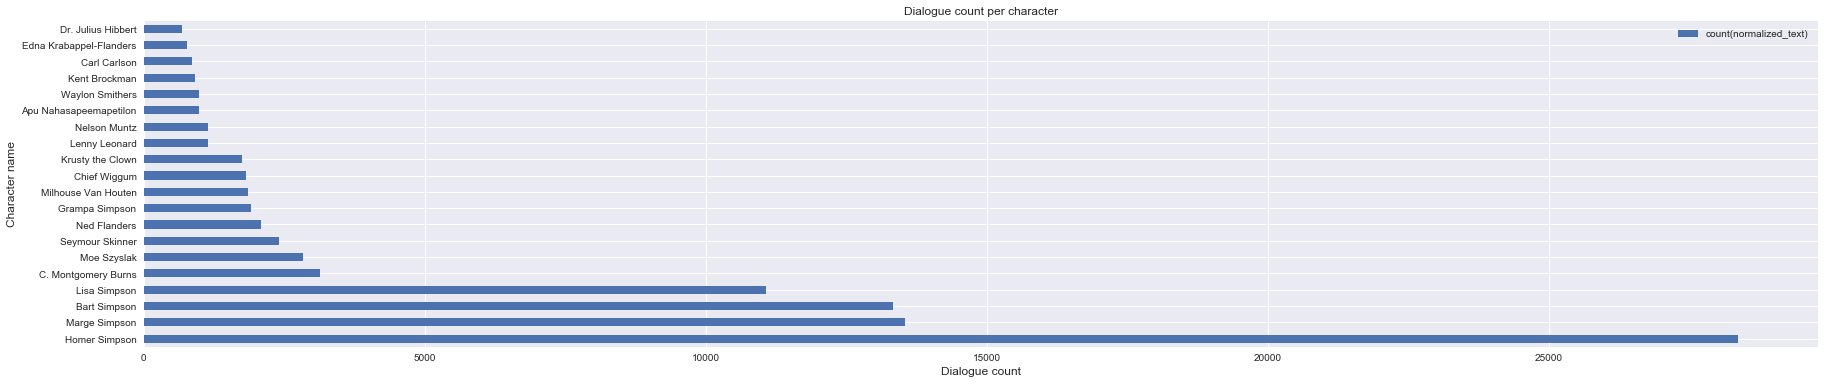

In [4]:
df_most_active_characters = pd.read_sql("select character_name, count(normalized_text) from(select distinct season,episode_id,character_id,character_name, Script_Lines.normalized_text from Script_Lines inner join Characters on Characters.id=Script_Lines.character_id inner join Episode on Episode.id=Script_Lines.episode_id) as temp group by character_name order by 2 desc limit 20",con=connection);

#df_most_active_characters
characters=[]
df_most_active_characters['character_name']
for x in df_most_active_characters['character_name']:
   characters.append(x)


ax = df_most_active_characters.plot(x='character_name',y='count(normalized_text)',kind='barh')
ax.set_ylabel("Character name", fontsize=12)
ax.set_xlabel("Dialogue count", fontsize=12)
plt.title('Dialogue count per character')
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

In [9]:
total_dialogues=pd.read_sql("select count(normalized_text) from(select distinct season,episode_id,character_id,character_name, Script_Lines.normalized_text from Script_Lines inner join Characters on Characters.id=Script_Lines.character_id inner join Episode on Episode.id=Script_Lines.episode_id) as temp",con=connection);
total_dialogues.head()

count(normalized_text)
0                  135178

In [10]:
df_most_active_characters.head(5)

character_name  count(normalized_text)
0        Homer Simpson                   28360
1        Marge Simpson                   13540
2         Bart Simpson                   13334
3         Lisa Simpson                   11077
4  C. Montgomery Burns                    3143

In [11]:
percentage_of_homer_dialogues=(28360/135178)*100
percentage_of_marge_dialogues=(13540/135178)*100
percentage_of_bart_dialogues=(13334/135178)*100
percentage_of_lisa_dialogues=(11077/135178)*100

In [12]:
print('Homer: ',percentage_of_homer_dialogues,', Marge: ',percentage_of_marge_dialogues, ',Bart:', percentage_of_bart_dialogues,', Lisa', percentage_of_lisa_dialogues)

Homer:  20.97974522481469 , Marge:  10.016422790690793 ,Bart: 9.864031129325777 , Lisa 8.194380742428502


Yes! correctly so!! Homer Simpson is the  most active character of the series. 
Moreover, Simpsons family combines consists of the about more than 45% of the dialogues spoken

If we Exclude the Simpsons nuclear family, we can see that the next famous characters are:

Mr Burns, Moe, Ned Flanders, Skinner, Grampa Simpson

Mr. Burns speaks the most words among supporting cast members, followed by Moe, Principal Skinner, Ned Flanders, and Grampa Simpson rounding out the top 5.



Classify the characters according to the gender

In [13]:
df_characters['gender']=df_characters['gender'].replace(['f\r'], 'female')
df_characters['gender']=df_characters['gender'].replace(['m\r'], 'male')
df_characters['gender']=df_characters['gender'].replace(['\r'], 'unknown')

In [14]:
df_characters.head(5)

id   character_name  normalized_name  gender
0   1    Marge Simpson    marge simpson  female
1   2    Homer Simpson    homer simpson    male
2   3  Seymour Skinner  seymour skinner    male
3   4            JANEY            janey  female
4   5    Todd Flanders    todd flanders    male

In [15]:
df_characters1=df_characters.copy()
df_characters1=df_characters[df_characters['gender']!='unknown']
df_characters1=df_characters1.drop(['id', 'character_name','normalized_name'] ,axis=1)
df_characters1.describe()

gender
count     323
unique      2
top      male
freq      252

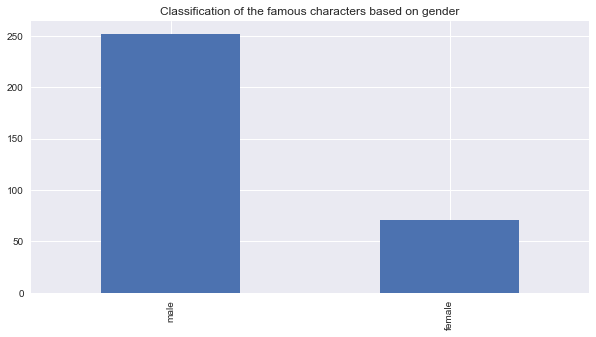

In [16]:
df_characters1['gender'].value_counts().plot(kind='bar')
plt.rcParams['figure.figsize'] = (10, 5)
plt.title('Classification of the famous characters based on gender')
plt.show()

We can see that majorly the characters appeared in the series are males. Lets see the percentage of dialogues spoken by females and males in the entire series

In [17]:
df_characters_female = pd.read_sql(" select character_name,count(normalized_text)from characters inner join script_lines on script_lines.character_id=characters.id where gender like '%f%' group by character_name order by 2 desc",con=connection);
df_characters_female.head()

character_name  count(normalized_text)
0            Marge Simpson                   14265
1             Lisa Simpson                   11641
2  Edna Krabappel-Flanders                     781
3            Selma Bouvier                     612
4            Patty Bouvier                     479

In [18]:
total_dialogues_by_all_females=sum(df_characters_female['count(normalized_text)'])
total_dialogues_by_all_females

31217

In [19]:
df_characters_male = pd.read_sql(" select character_name,count(normalized_text) from characters inner join script_lines on script_lines.character_id=characters.id where gender like '%m%' group by character_name order by 2 desc",con=connection);
df_characters_male.head()

character_name  count(normalized_text)
0        Homer Simpson                   30108
1         Bart Simpson                   13969
2  C. Montgomery Burns                    3207
3          Moe Szyslak                    2864
4      Seymour Skinner                    2443

In [20]:
total_dialogues_by_all_males=sum(df_characters_male['count(normalized_text)'])
total_dialogues_by_all_males

87233

In [21]:
percentage_of_dialogues_by_males=total_dialogues_by_all_males*100/132088
percentage_of_dialogues_by_females=total_dialogues_by_all_females*100/132088

print('Males:',percentage_of_dialogues_by_males, 'Females: ',percentage_of_dialogues_by_females)

Males: 66.0415783417 Females:  23.6334867664


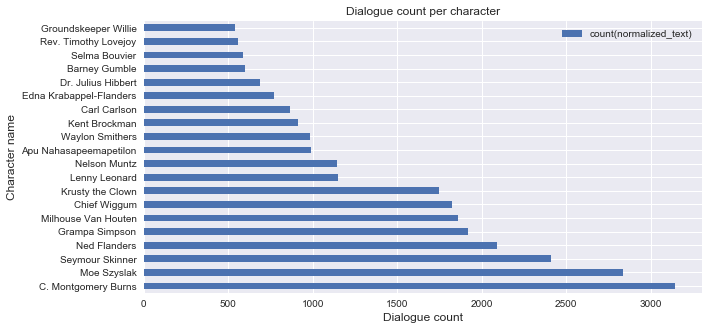

In [22]:
df_most_active_supporting_characters = pd.read_sql("select character_name, count(normalized_text),gender  from(select distinct season,episode_id,character_id,character_name,gender, Script_Lines.normalized_text from Script_Lines inner join Characters on Characters.id=Script_Lines.character_id inner join Episode on Episode.id=Script_Lines.episode_id) as temp where character_id not in (9,1,2,8)group by character_name order by 2 desc limit 20",con=connection);

#df_most_active_characters
characters=[]
df_most_active_supporting_characters['character_name']
for x in df_most_active_supporting_characters['character_name']:
   characters.append(x)


ax = df_most_active_supporting_characters.plot(x='character_name',y='count(normalized_text)',kind='barh')
ax.set_ylabel("Character name", fontsize=12)
ax.set_xlabel("Dialogue count", fontsize=12)
plt.title('Dialogue count per character')
plt.rcParams['figure.figsize'] = (10, 7)
plt.show()

In [23]:
df_most_active_supporting_characters['gender']=df_most_active_supporting_characters['gender'].replace('m\r','male')
df_most_active_supporting_characters['gender']=df_most_active_supporting_characters['gender'].replace('f\r','female')
df_most_active_supporting_characters

character_name  count(normalized_text)  gender
0       C. Montgomery Burns                    3143    male
1               Moe Szyslak                    2833    male
2           Seymour Skinner                    2412    male
3              Ned Flanders                    2093    male
4            Grampa Simpson                    1916    male
5       Milhouse Van Houten                    1859    male
6              Chief Wiggum                    1827    male
7          Krusty the Clown                    1748    male
8             Lenny Leonard                    1150    male
9              Nelson Muntz                    1145    male
10   Apu Nahasapeemapetilon                     990    male
11          Waylon Smithers                     986    male
12            Kent Brockman                     913    male
13             Carl Carlson                     866    male
14  Edna Krabappel-Flanders                     770  female
15       Dr. Julius Hibbert                     686    male
16            Barney Gumble                     599    male
17            Selma Bouvier                     588  female
18     Rev. Timothy Lovejoy                     559    male
19     Groundskeeper Willie                     538    male

We can see that 90% of the supporting characters are males

Let us perform some exploratory analysis depending on the location

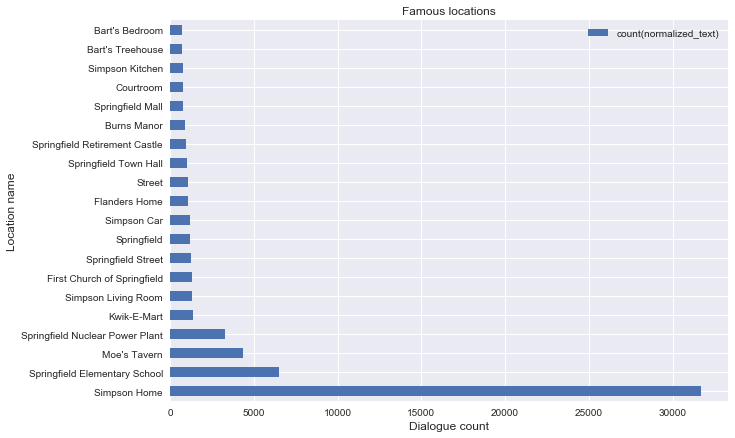

In [24]:
df_most_active_locations = pd.read_sql("select location_name, count(normalized_text) from(select distinct season,episode_id,character_id,location_name, Script_Lines.normalized_text from Script_Lines inner join locations on locations.id=Script_Lines.location_id inner join Episode on Episode.id=Script_Lines.episode_id) as temp group by location_name order by 2 desc limit 20",con=connection);

locations=[]
df_most_active_locations['location_name']
for x in df_most_active_locations['location_name']:
   locations.append(x)


ax = df_most_active_locations.plot(x='location_name',y='count(normalized_text)',kind='barh')
ax.set_ylabel("Location name", fontsize=12)
ax.set_xlabel("Dialogue count", fontsize=12)
plt.title('Famous locations')
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

As expected, the most actove location is the Simpson Home.  Ideally, the living room and kitchen are also considered as a part of Simpsons Home
But, we get a clear picture about the top most active locations of the series

In [25]:
df_script_lines.corr()

id  episode_id  line_num  timestamp_in_ms  \
id               1.000000    0.999775 -0.050055        -0.030934   
episode_id       0.999775    1.000000 -0.051893        -0.032589   
line_num        -0.050055   -0.051893  1.000000         0.959806   
timestamp_in_ms -0.030934   -0.032589  0.959806         1.000000   
character_id     0.253793    0.253766  0.028490         0.031442   
location_id      0.323982    0.323098  0.081171         0.077840   
word_count      -0.002985   -0.003015  0.003531         0.002736   

                 character_id  location_id  word_count  
id                   0.253793     0.323982   -0.002985  
episode_id           0.253766     0.323098   -0.003015  
line_num             0.028490     0.081171    0.003531  
timestamp_in_ms      0.031442     0.077840    0.002736  
character_id         1.000000     0.244851    0.001308  
location_id          0.244851     1.000000   -0.000253  
word_count           0.001308    -0.000253    1.000000

Unfortunately, no good correlation is observed and rightly so it is not even expected to get a high correlation for this dataset

Analysis of Simpson series episode ratings.

In [26]:
df_epsiode_rating = pd.read_sql("select id ,title,  imdb_rating  from Episode order by 3 desc", con=connection)
df_epsiode_rating.head()

id                                   title  imdb_rating
0  155                     You Only Move Twice          9.2
1  176                           Homer's Enemy          9.2
2  128          Who Shot Mr. Burns? (Part One)          9.1
3  179  The City of New York vs. Homer Simpson          9.1
4   62                       Homer the Heretic          9.0

In [27]:
df_epsiode_rating_best=df_epsiode_rating.head(25)
df_epsiode_rating_worst=df_epsiode_rating.tail(25)
df_epsiode_rating_worst = df_epsiode_rating_worst[df_epsiode_rating_worst.imdb_rating != 0]

In [28]:
df_epsiode_rating_best.head(10)

id                                   title  imdb_rating
0  155                     You Only Move Twice          9.2
1  176                           Homer's Enemy          9.2
2  128          Who Shot Mr. Burns? (Part One)          9.1
3  179  The City of New York vs. Homer Simpson          9.1
4   62                       Homer the Heretic          9.0
5   71                  Marge vs. the Monorail          9.0
6   76                Last Exit to Springfield          9.0
7   83                              Cape Feare          9.0
8  109                   Treehouse of Horror V          9.0
9  112                            Homer Badman          9.0

In [29]:
df_epsiode_rating_worst.tail(10)

id                                 title  imdb_rating
587  575                     Every Man's Dream          5.9
588  429                  Lisa the Drama Queen          5.9
589  549  What to Expect When Bart's Expecting          5.8
590  553                    Clown in the Dumps          5.8
591  564            The Musk Who Fell to Earth          5.8
592  457        The Greatest Story Ever D'ohed          5.7
593  498          Moe Goes from Rags to Riches          5.7
594  286                            Gump Roast          5.6
595  189              All Singing, All Dancing          5.1
596  508                        Lisa Goes Gaga          4.5

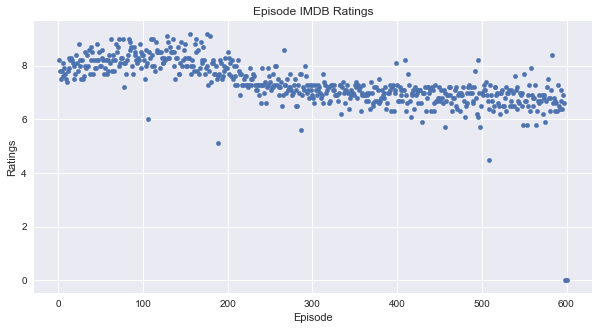

In [30]:
(df_epsiode_rating
 .plot
 .scatter(x='id', y='imdb_rating')
 .set(title='Episode IMDB Ratings',
      xlabel='Episode',
      ylabel='Ratings'))
plt.rcParams['figure.figsize'] = (10,7)
plt.show()

The ratings seem to have fallen gradually over the time. 
The drop in the rating is from 9.2 max to about 6.8 or so along with some one or two bigger drops here and there like the episodes with 4.2 or 5. We will further investigate on why was there a big fall of the ratings for these episodes

Characters in the worst epsiode

In [31]:
df_characters_of_worst_episode_508=pd.read_sql("select character_id ,raw_character_text, count(normalized_text) from Script_lines where episode_id=508 group by raw_character_text order by 3 desc", con=connection)

In [32]:
df_characters_of_worst_episode_508=df_characters_of_worst_episode_508[df_characters_of_worst_episode_508['raw_character_text']!='']
df_characters_of_worst_episode_508

character_id         raw_character_text  count(normalized_text)
0         6127.0                  Lady Gaga                      78
1            9.0               Lisa Simpson                      54
3            2.0              Homer Simpson                      19
4            1.0              Marge Simpson                      13
5            8.0               Bart Simpson                      12
6            3.0            Seymour Skinner                       6
7           17.0                Moe Szyslak                       6
8           11.0               Ned Flanders                       5
9           75.0                      Crowd                       5
10          41.0                  Conductor                       4
11          25.0        Milhouse Van Houten                       4
12          56.0                   Narrator                       4
13        6130.0        Dangling Accountant                       3
14          39.0                       Kids                       3
15        1875.0           Brandine Del Roy                       3
16         144.0                Jimbo Jones                       3
17         145.0           Kearney Zzyzwicz                       3
18          31.0             Grampa Simpson                       3
19          71.0               Chief Wiggum                       2
20         433.0                     Farmer                       2
21        6125.0                   Farmwife                       2
22        5978.0                  Tsa Agent                       2
23         183.0                    Manager                       2
24          54.0         Sherri Mackleberry                       2
25          55.0          Terri Mackleberry                       2
26         101.0               Nelson Muntz                       2
27        6135.0                Egg Bearers                       2
28         119.0               Ralph Wiggum                       1
29        6126.0                    Pistons                       1
30        6128.0           Senior Tsa Agent                       1
31          38.0              Martin Prince                       1
32        6129.0               Wardrobe Man                       1
33        1413.0            Cletus Spuckler                       1
34        6131.0               SPUCKLER KID                       1
35         211.0              Kent Brockman                       1
36        6132.0                   CROWD OW                       1
37         165.0              Lenny Leonard                       1
38        6133.0                 Voice Chip                       1
39        6134.0          Manhole Paparazzo                       1
40         943.0  Just Stamp the Ticket Man                       1
41        6136.0                 Egg Bearer                       1
42         801.0             Comic Book Guy                       1
43          33.0                  Announcer                       1

In [33]:
sum_of_dialogues=sum(df_characters_of_worst_episode_508['count(normalized_text)'])
sum_of_dialogues

262

Seems that Lady Gaga's appearance did not please the audience much!!

The episode with the lowest imdb rating has good number of  total characters and dialogues in it.
Even then, it is rated as the worst. We can predict two reasons for this one.
Either the Episode was not very funny or Lady Gaga's appearance did not please the audience much!!

Will check in which all episodes did Lady Gaga appear and what is the rating of thos epsiodes.
If all of them seem to be less than average, we can conclude that her appearance is not very pleasing to the audience

In [34]:
df_episodes_of_Lady_Gaga=pd.read_sql("select episode_id ,raw_character_text, count(normalized_text) from Script_lines where character_id=6127 group by raw_character_text order by 3 desc", con=connection)

In [35]:
df_episodes_of_Lady_Gaga

episode_id raw_character_text  count(normalized_text)
0         508          Lady Gaga                      78

Ops!! She seems to have appeared in only one epsiode!! So wont be able to further predict on this case. Let us analyze one another case

Second worst Episode

In [36]:
df_characters_of_worst_episode_189=pd.read_sql("select character_id ,raw_character_text, count(normalized_text) from Script_lines where episode_id=189 group by raw_character_text order by 3 desc", con=connection)
df_characters_of_worst_episode_189=df_characters_of_worst_episode_189[df_characters_of_worst_episode_189['raw_character_text']!='']
df_characters_of_worst_episode_189

character_id    raw_character_text  count(normalized_text)
0            2.0         Homer Simpson                      18
1            1.0         Marge Simpson                      14
2          518.0        Snake Jailbird                      13
3            8.0          Bart Simpson                      10
4            9.0          Lisa Simpson                       9
5         2385.0                Hombre                       3
6         2386.0        Clint Eastwood                       3
7         2388.0            Lee Marvin                       3
9         2387.0    Townspeople Chorus                       1
10        2389.0         Female Chorus                       1
11        2390.0  SECOND FEMALE CHORUS                       1
12         658.0              Everyone                       1
13         109.0                   All                       1

In [37]:
sum_of_dialogues=sum(df_characters_of_worst_episode_189['count(normalized_text)'])
sum_of_dialogues

78

This seems to be poor rated epsiode because there are very less characters and dialogues spoken.

In [38]:
df_episodes

id                                              title original_air_date  \
0      1                  Simpsons Roasting on an Open Fire        12/17/1989   
1      2                                    Bart the Genius         1/14/1990   
2      3                                    Homer's Odyssey         1/21/1990   
3      4                      There's No Disgrace Like Home         1/28/1990   
4      5                                   Bart the General          2/4/1990   
5      6                                       Moaning Lisa         2/11/1990   
6      7                           The Call of the Simpsons         2/18/1990   
7      8                                  The Telltale Head         2/25/1990   
8      9                              Life on the Fast Lane         3/18/1990   
9     10                                  Homer's Night Out         3/25/1990   
10    11                                The Crepes of Wrath         4/15/1990   
11    12                                 Krusty Gets Busted         4/29/1990   
12    13                             Some Enchanted Evening         5/13/1990   
13    14                                   Bart Gets an "F"        10/11/1990   
14    15                                Simpson and Delilah        10/18/1990   
15    16                                Treehouse of Horror        10/25/1990   
16    17  Two Cars in Every Garage and Three Eyes on Eve...         11/1/1990   
17    18                                      Dancin' Homer         11/8/1990   
18    19                               Dead Putting Society        11/15/1990   
19    20                              Bart vs. Thanksgiving        11/22/1990   
20    21                                 Bart the Daredevil         12/6/1990   
21    22                           Itchy & Scratchy & Marge        12/20/1990   
22    23                             Bart Gets Hit by a Car         1/10/1991   
23    24            One Fish, Two Fish, Blowfish, Blue Fish         1/24/1991   
24    25                                     The Way We Was         1/31/1991   
25    26             Homer vs. Lisa and the 8th Commandment          2/7/1991   
26    27                                 Principal Charming         2/14/1991   
27    28                        Oh Brother, Where Art Thou?         2/21/1991   
28    29                             Bart's Dog Gets an "F"          3/7/1991   
29    30                                          Old Money         3/28/1991   
..   ...                                                ...               ...   
570  571                             The Kids Are All Fight         4/26/2015   
571  572                                Let's Go Fly a Coot          5/3/2015   
572  573                                             Bull-E         5/10/2015   
573  574                                    Mathlete's Feat         5/17/2015   
574  575                                  Every Man's Dream         9/27/2015   
575  576                                      Cue Detective         10/4/2015   
576  577                                           Puffless        10/11/2015   
577  578                                Halloween of Horror        10/18/2015   
578  579                           Treehouse of Horror XXVI        10/25/2015   
579  580                                Friend with Benefit         11/8/2015   
580  581                                   Lisa with an 'S'        11/22/2015   
581  582                                     Paths of Glory         12/6/2015   
582  583                                           Barthood        12/13/2015   
583  584                                      The Girl Code          1/3/2016   
584  585                 Teenage Mutant Milk-Caused Hurdles         1/10/2016   
585  586                           Much Apu About Something         1/17/2016   
586  587              Love Is in the N2-O2-Ar-CO2-Ne-He-CH4         2/14/2016   
587  588                             

In [39]:
df_episodes.dtypes

id                          int64
title                      object
original_air_date          object
production_code            object
season                      int64
number_in_season            int64
number_in_series            int64
us_viewers_in_millions    float64
views                     float64
imdb_rating               float64
imdb_votes                  int64
image_url                  object
video_url                  object
dtype: object

In [40]:
df_episodes['original_air_date']=pd.to_datetime(df_episodes['original_air_date'])


In [41]:
df_episodes['year'] = pd.DatetimeIndex(df_episodes['original_air_date']).year

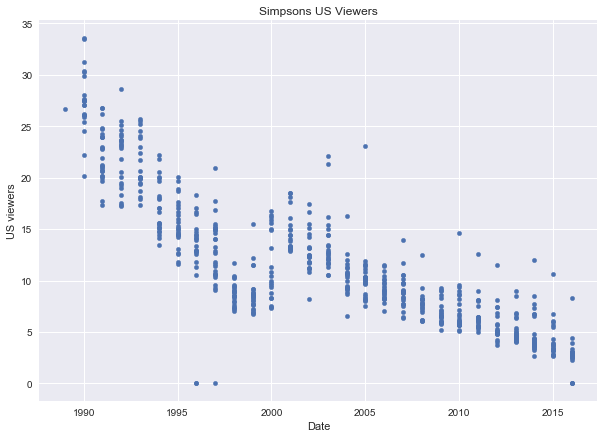

In [42]:
(df_episodes
 .plot
 .scatter(x='year', y='us_viewers_in_millions')
 .set(title='Simpsons US Viewers',
      xlabel='Date',
      ylabel='US viewers'))
plt.rcParams['figure.figsize'] = (10,5)
plt.show()

The viewers seem to have been decreasing over the time

Below is some analysis of word count for better understanding of data, most frequently used words in the series and their frequencies.

In [43]:
all_text=df_script_lines['normalized_text']

In [44]:
all_text_string=" ".join(all_text)

In [45]:
all_text_string[:99]

'  ooo careful homer theres no time to be careful were late   sorry excuse us pardon me hey norman h'

In [46]:
from nltk.tokenize import word_tokenize, sent_tokenize
sentences=sent_tokenize(all_text_string)
#sentences[:1]

In [47]:
words=[word_tokenize(s) for s in sentences]
#words[:2]

In [48]:
def extract_counts(sentences):
    n_sents = len(sentences)
    n_words = 0
    n_chars = 0
    for sentence in sentences:
        n_words +=  len(sentence)
        for word in sentence:
            n_chars += len(word)
            
    return n_chars, n_words,n_sents

In [49]:
ec = extract_counts(words) # n_chars, n_words, n_sents
ec

(5364213, 1311406, 63)

In [50]:
from nltk.corpus import stopwords
stop=stopwords.words('english')

In [51]:
from nltk.corpus import stopwords 
from string import punctuation
my_stopwords=set(stopwords.words('english')+list(punctuation))

In [52]:
from nltk.stem.lancaster import LancasterStemmer
st=LancasterStemmer()
stemmed_words=[st.stem(word) for word in word_tokenize(all_text_string)]
#stemmed_words[:33]

In [53]:
words = word_tokenize(all_text_string.lower())
#words[:33]

In [54]:
words=[word for word in words if word not in my_stopwords]
#words[:33]

In [55]:
from nltk.probability import FreqDist
counts = FreqDist(words)
#counts.head(1000)

In [56]:
from heapq import nlargest
nlargest(10, counts, key=counts.get)

['im', 'oh', 'well', 'dont', 'like', 'get', 'youre', 'know', 'one', 'got']

In [57]:
vocab   = len(counts.keys())
words   = sum(counts.values())
lexdiv  = float(words) / float(vocab)

print ("Corpus has %i word types and %i word counts for a lexical diversity of %0.3f" % (vocab, words, lexdiv))

Corpus has 46208 word types and 742936 word counts for a lexical diversity of 16.078


In [58]:
#counts#.most_common(10)
counts.most_common(10)
#counts

[('im', 9433),
 ('oh', 8166),
 ('well', 7023),
 ('dont', 6878),
 ('like', 5967),
 ('get', 5219),
 ('youre', 5037),
 ('know', 4728),
 ('one', 4655),
 ('got', 4624)]

In [59]:
with open("c:/users/nehah/counts.csv", "w") as file:
    writer = csv.writer(file, delimiter=",")
    writer.writerow([counts])

In [60]:
counts.freq('like')

0.008031647409736505

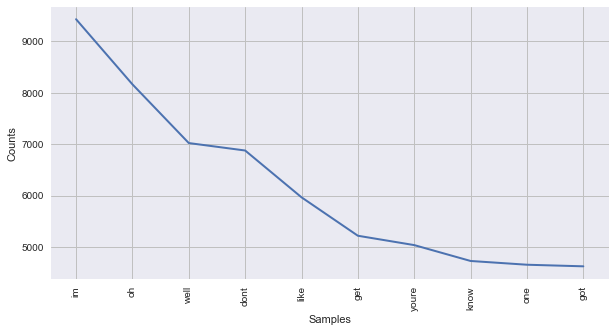

In [61]:
counts.plot(10, cumulative=False)

The above counts describe the highest frequency words in the series. The same results are seen when we make a word cloud

Calculating the TF-IDF

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')

In [72]:
# normalized_text=[]
# for row in df_script_lines:
#      normalized_text.append(df_script_lines['normalized_text'])

In [73]:
#sentences[:5]

In [74]:
tfidf_matrix =  tf.fit_transform(sentences)
feature_names = tf.get_feature_names() 
len(feature_names)

1119234

In [75]:
#feature_names[1000:2000]

In [76]:
tfidf_matrix

<63x1119234 sparse matrix of type '<class 'numpy.float64'>'
	with 1415303 stored elements in Compressed Sparse Row format>

In [79]:
dense = tfidf_matrix.todense()
len(dense[0].tolist()[0])

1119234

In [80]:
episode = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(episode)), episode) if pair[1] > 0]
len(phrase_scores)

3275

In [81]:
sorted(phrase_scores, key=lambda t: t[1] * -1)[:5]

[(425395, 0.28167836949718184),
 (425416, 0.27943036364425367),
 (425292, 0.23428044285167915),
 (145580, 0.15414391319403922),
 (686377, 0.12591761579230376)]

In [82]:
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:50]:
   print('{0: <50} {1}'.format(phrase, score))

ho ho                                              0.28167836949718184
ho ho ho                                           0.27943036364425367
ho                                                 0.23428044285167915
christmas                                          0.15414391319403922
oh                                                 0.12591761579230376
santas                                             0.12278287901159209
little                                             0.11339569890281508
whirlwind                                          0.09269946076957748
santas little                                      0.0834381940899671
santas little helper                               0.0834381940899671
little helper                                      0.08138751821486166
helper                                             0.07760749261350107
santa                                              0.07752690663075729
dad                                                0.07203798731870181
homer   

The motive for above exercise was to identify if there are frequently used phrases in the series. If there would have been some valueable phrases which were repeated and express similar type of sentiment, it would have helped us identify special idioms for our series while creation of our dictionery. 

Conclusion:

The exploratory analysis of the dataset has helped us the following:
    
Identify the most active characters of the series.

Most active locations of the series.

Partial reasons for poorly rated episodes.

IMDB rating graphs over the seasons.

Viewers statistics over the seasons.

Count the frequency of important words used in the series.

Calculated and checked the Term frequency -Inverse Document frequency for the phrases in the dataset.